In [15]:
import cv2
import matplotlib.pyplot as plt
import zipfile
import numpy as np
cv2.__version__

'4.11.0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
caminhoPose = '/content/drive/MyDrive/projetinhos/libras/pose.zip'
extrairArquivo = zipfile.ZipFile(file = caminhoPose, mode = 'r')
extrairArquivo.extractall()

In [4]:
caminhoImg = '/content/drive/MyDrive/projetinhos/libras/imagens.zip'
extrairArquivo = zipfile.ZipFile(file = caminhoImg, mode = 'r')
extrairArquivo.extractall()

carregando modelos e estruturas de rede neural pré treinadas


In [7]:
arquivoProto = '/content/pose/body/mpi/pose_deploy_linevec_faster_4_stages.prototxt'
arquivoPeso = '/content/pose/body/mpi/pose_iter_160000.caffemodel'

Ligação entres os pares para formação da linha

In [8]:
numeroPontos = 15
#para saber qual par ligar com quem, investigue a documentação e ache a respeito da posição dos pontos do cafee
paresPontos = [[0,1], [1,2], [2,3], [3,4], [4,5], [5,6], [6,7], [1,14],
                [14,8], [8,9], [14,11], [11,12], [12,13]]

In [9]:
corPonto, corLinha = (255, 128, 0), (7, 62, 248)

In [12]:
img = cv2.imread('/content/imagens/body/single/single_3.jpg')

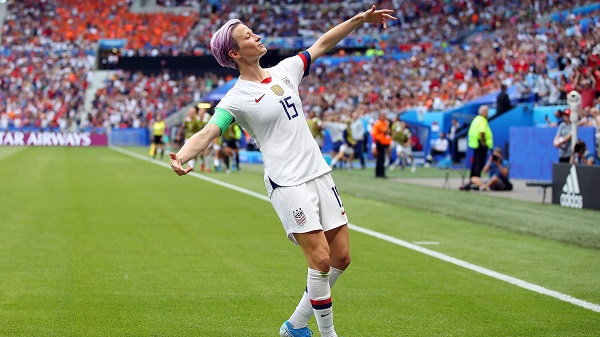

In [13]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [16]:
imgCopia = np.copy(img)

In [20]:
imgW, imgH = img.shape[1], img.shape[0]

In [21]:
modelo = cv2.dnn.readNetFromCaffe(arquivoProto, arquivoPeso)

In [25]:
entradaDimensaoH = 368
entradaDimensaoW = int((entradaDimensaoH/imgH)*imgW)

In [26]:
blobEntrada = cv2.dnn.blobFromImage(img, 1.0/255, (entradaDimensaoW, entradaDimensaoH), (0,0,0), swapRB=False, crop=False)

In [27]:
modelo.setInput(blobEntrada)
saida = modelo.forward()

In [28]:
altura = saida.shape[2]
largura = saida.shape[3]

protanso saida da imagem

In [38]:
pontos = []
limite = 0.1

for i in range(numeroPontos):
  mapaConfianca = saida[0, i, :, :]
  _, confianca, _, ponto = cv2.minMaxLoc(mapaConfianca)

  x = int(imgW * ponto[0] / largura)
  y = int(imgH * ponto[1] / altura)

  if confianca > limite:
    cv2.circle(imgCopia, (int(x), int(y)), 8, corPonto, thickness=-1, lineType=cv2.FILLED)
    cv2.putText(imgCopia, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, corPonto, 3, lineType=cv2.LINE_AA)
    pontos.append((int(x), int(y)))
  else:
    pontos.append(None)

In [39]:
len(pontos)

15

maslara para o desenho do esqueleto (fundo preto)

In [40]:
tamanho = cv2.resize(img, (imgW, imgH))
mapaSuavessito = cv2.GaussianBlur(tamanho, (3,3), 0,0)
mkrMapa = np.uint8(mapaSuavessito > limite)

In [41]:
for par in paresPontos:
  partA = par[0]
  partB = par[1]

  if pontos[partA] and pontos[partB]:
    cv2.line(mkrMapa, pontos[partA], pontos[partB], corLinha, 3)
    cv2.circle(mkrMapa, pontos[partA], 8, corPonto, thickness=-1, lineType=cv2.LINE_AA)

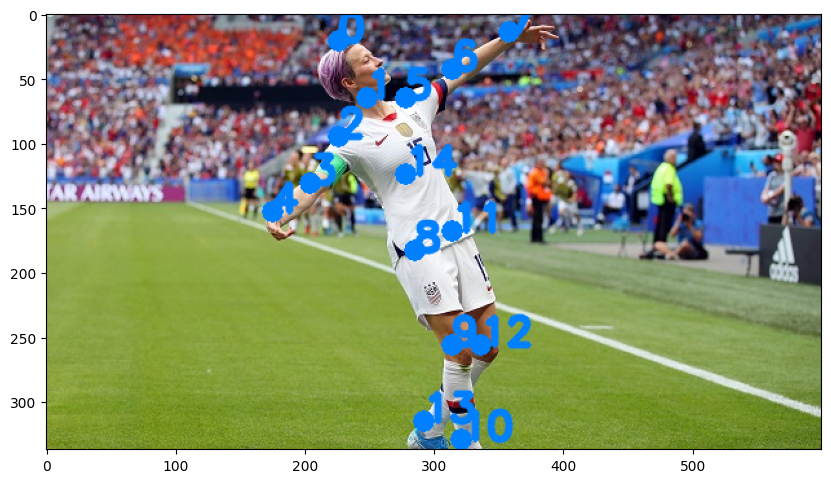

In [42]:
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(imgCopia, cv2.COLOR_BGR2RGB))

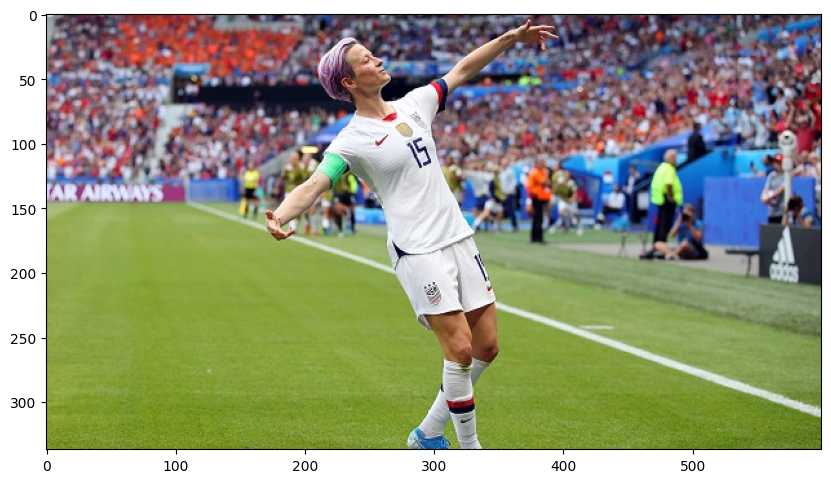

In [43]:
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

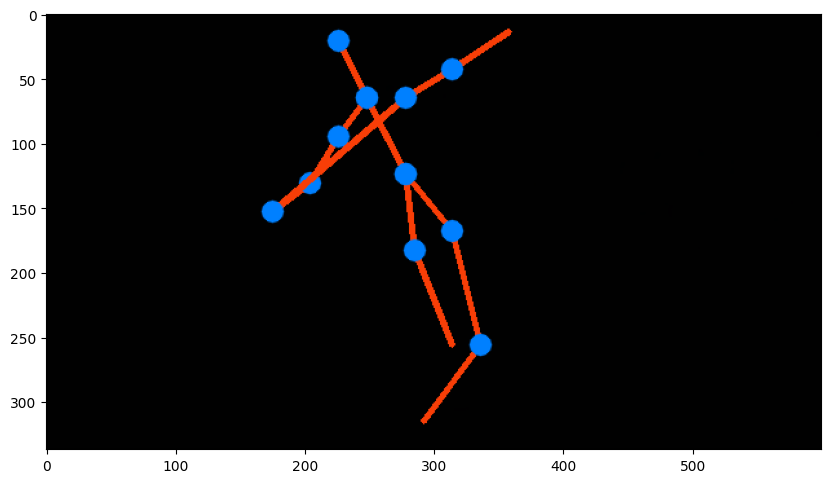

In [44]:
plt.figure(figsize=[10,10])
plt.imshow(cv2.cvtColor(mkrMapa, cv2.COLOR_BGR2RGB))